### sklearn example
Ref: https://scikit-learn.org/stable/modules/metrics.html
Chinese: https://www.studyai.cn/modules/metrics.html

In [6]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
X = np.array([[2, 3], [3, 5], [5, 8]])
Y = np.array([[1, 0], [2, 1], [2, 3]])
pairwise_distances(X, Y, metric='manhattan')
pairwise_distances(X, metric='manhattan')
pairwise_kernels(X, Y, metric='linear')

array([[ 2.,  7., 13.],
       [ 3., 11., 21.],
       [ 5., 18., 34.]])

#### RBF

In [7]:
"""
gamma : float, default None

If None, defaults to 1.0 / n_features
"""

pairwise_kernels(X, Y, 'rbf') 

array([[6.73794700e-03, 1.35335283e-01, 1.00000000e+00],
       [5.04347663e-07, 2.03468369e-04, 8.20849986e-02],
       [4.24835426e-18, 2.54366565e-13, 4.13993772e-08]])

In [5]:
from sklearn.metrics.pairwise import rbf_kernel
rbf_kernel(X, Y)

array([[6.73794700e-03, 1.35335283e-01],
       [5.04347663e-07, 2.03468369e-04],
       [4.24835426e-18, 2.54366565e-13]])

In [12]:
# K(x, y) = exp(-gamma ||x - y||^2)
np.exp(-(1 / 2) * (np.sum((X[0] - Y[0]) ** 2)))

0.006737946999085467

#### Polynomial

In [16]:
pairwise_kernels(X, Y, 'polynomial', degree=3) # drgree default 3 

array([[   8.   ,   91.125,  421.875],
       [  15.625,  274.625, 1520.875],
       [  42.875, 1000.   , 5832.   ]])

#### Laplacian

In [17]:
pairwise_kernels(X, Y, 'laplacian')

array([[0.13533528, 0.36787944, 1.        ],
       [0.03019738, 0.082085  , 0.22313016],
       [0.00247875, 0.00673795, 0.01831564]])

### Implement MMD and Kernel-Two-Sample-Test (KTST)

##### MMD statistics
paper: http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf
![MMD2U](MMD_2_unbiased.PNG)

In [19]:
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    m: length of sample 1 matrix
    n: length of sample 2 matrix
    K: pairwise distance (maybe RBF or some) matrix
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
           1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
           2.0 / (m * n) * Kxy.sum()

##### KTST
Ref: https://github.com/emanuele/kernel_two_sample_test/blob/master/kernel_two_sample_test.py

In [38]:
def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null

### Example
Ref: https://blog.csdn.net/a529975125/article/details/81176029
Data preparation

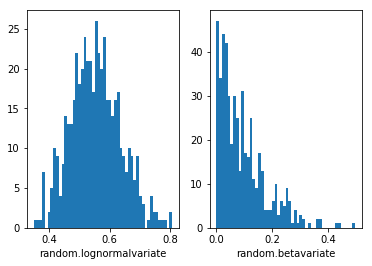

499


In [23]:
import random
import matplotlib
import matplotlib.pyplot as plt

SAMPLE_SIZE = 500
buckets = 50

#第一种分布：对数正态分布，得到一个中值为mu，标准差为sigma的正态分布。mu可以取任何值，sigma必须大于零。
plt.subplot(1,2,1)
plt.xlabel("random.lognormalvariate")
mu = -0.6
sigma = 0.15#将输出数据限制到0-1之间
res1 = [random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res1, buckets)

#第二种分布：beta分布。参数的条件是alpha 和 beta 都要大于0， 返回值在0~1之间。
plt.subplot(1,2,2)
plt.xlabel("random.betavariate")
alpha = 1
beta = 10
res2 = [random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res2, buckets)

plt.show()

1. 分别从不同分布取两组数据（每组为10*500）

In [37]:
import torch
from torch.autograd import Variable

#参数值见上段代码
#分别从对数正态分布和beta分布取两组数据
diff_1 = []
for i in range(10):
    diff_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

diff_2 = []
for i in range(10):
    diff_2.append([random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(diff_1)
Y = torch.Tensor(diff_2)
X,Y = Variable(X), Variable(Y)

###
kernel_function = 'rbf'
m = len(X)
n = len(Y)
XY = np.vstack([X, Y])
K = pairwise_kernels(XY, metric=kernel_function)
mmd2u = MMD2u(K, m, n)

print(mmd2u)

0.38281568739149296


2. 分别从相同分布取两组数据（每组为10*500）

In [41]:
from torch.autograd import Variable

#参数值见以上代码
#从对数正态分布取两组数据
same_1 = []
for i in range(10):
    same_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

same_2 = []
for i in range(10):
    same_2.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(same_1)
Y = torch.Tensor(same_2)
X,Y = Variable(X), Variable(Y)

###
kernel_function = 'rbf'
m = len(X)
n = len(Y)
XY = np.vstack([X, Y])
K = pairwise_kernels(XY, metric=kernel_function)
mmd2u = MMD2u(K, m, n)

print(mmd2u)

-0.00014370388454865157
